In [1]:
#| default_exp data

# Data loading

> Always make sure you can load all your data.

Stablishing a data-loading pipeline is always a good starting point for starting every project. In this case in particular, we have to be conscious because each `.edf` file we are going to work with is about 1 Gb, so performing lazy loading might become crucial for the project.

In [56]:
#| exports
import os
from tqdm.auto import tqdm
from glob import glob
from collections import Counter
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import mne
import yasa

In [3]:
#| hide
path_data = "/media/2tbraid/antonia/PSG/"

## Loading `.edf` files

> We will be using `mne.io.read_raw_edf`.

In [4]:
path_files = glob(os.path.join(path_data, "*.edf"))

In [5]:
raw = mne.io.read_raw_edf(path_files[0], preload=False)
raw

Extracting EDF parameters from /media/2tbraid/antonia/PSG/PSG29.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_227803/1189779846.py:1: RuntimeWarning: Omitted 200 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(path_files[0], preload=False)
/tmp/ipykernel_227803/1189779846.py:1: RuntimeWarning: Limited 2 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path_files[0], preload=False)


<RawEDF | PSG29.edf, 50 x 12198400 (23825.0 s), ~52 kB, data not loaded>

Now that we've loaded the file, we can downsample it to 100Hz and apply a low-pass filter to the signal:

In [6]:
# Downsample the data to 100 Hz
raw.resample(100)
# Apply a bandpass filter from 0.3 to 49 Hz
raw.filter(0.3, 49)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.3 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.30
- Lower transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.15 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 49.50 Hz)
- Filter length: 1101 samples (11.010 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.5s finished


<RawEDF | PSG29.edf, 50 x 2382500 (23825.0 s), ~908.9 MB, data loaded>

The different channels of the signal are available in the attribute `.ch_names`:

In [9]:
print(len(raw.ch_names))
raw.ch_names

50


['C3',
 'C4',
 'O1',
 'O2',
 'A1',
 'A2',
 'Cz',
 'F3',
 'F4',
 'F7',
 'F8',
 'Fz',
 'Fp1',
 'Fp2',
 'Fpz',
 'P3',
 'P4',
 'Pz',
 'T3',
 'T4',
 'T5',
 'T6',
 'LOC',
 'ROC',
 'CHIN1',
 'CHIN2',
 'ECGL',
 'ECGR',
 'LAT1',
 'LAT2',
 'RAT1',
 'RAT2',
 'CHEST',
 'ABD',
 'FLOW',
 'SNORE',
 'DIF5',
 'DIF6',
 'POS',
 'DC2',
 'DC3',
 'DC4',
 'DC5',
 'DC6',
 'DC7',
 'DC8',
 'DC9',
 'DC10',
 'OSAT',
 'PR']

We can extract a subset of the channels by using the methods `.pick_channels()` and `.drop_channels()`:

In [10]:
# Select a subset of EEG channels
# raw.pick_channels(['LOC-A2', 'ROC-A1', 'F3-A2', 'C3-A2', 'O1-A2', 'F4-A1', 'C4-A1', 'O2-A1', 'X1', 'X2', 'X3'])

## Making use of the annotations in the recordings

One of the peculiarities of this kind of data is they include medical annotations. We can access them in the atribute `.annotations`:

In [16]:
raw.annotations

<Annotations | 2057 segments: Central Apnea (6), EEG arousal (131), ...>

We can index this object to view more information:

In [17]:
raw.annotations[80]

OrderedDict([('onset', 3420.0),
             ('duration', 30.0),
             ('description', 'Sleep stage W'),
             ('orig_time',
              datetime.datetime(2019, 1, 1, 22, 48, 22, tzinfo=datetime.timezone.utc))])

As we can see, they include all the information needed to split the signal into *epochs*:

- `onset`: starting time of an epoch.
- `duration`: duration of the epoch.
- `description`: label set by the medical staff.
- `orig_time`: date when the data was collected.

We can use a `Counter` to count the different labels available in the data:

In [32]:
cntr = Counter(raw.annotations.description)
cntr

Counter({'Montage:PR, Ref': 2,
         'Start Recording': 1,
         'Recording Analyzer - Sleep Events': 1,
         'Recording Analyzer - Auto-Staging': 1,
         'Recording Analyzer - ECG': 1,
         'Recording Analyzer - Data Trends': 1,
         'Video Recording ON': 1,
         'Impedance at 10 kOhm': 1,
         'Obstructive Apnea': 200,
         'Patient Event': 2,
         'Sleep stage W': 367,
         'Lights Off': 1,
         'Started Analyzer - Sleep Events': 1,
         'Gain/Filter Change': 2,
         'Oxygen Desaturation': 341,
         'Oximeter Event': 272,
         'Limb Movement': 109,
         'Sleep stage N1': 29,
         'EEG arousal': 131,
         'Snoring': 251,
         'Sleep stage N2': 323,
         'Talking': 8,
         'ORINANDO': 2,
         'Hypopnea': 3,
         'Central Apnea': 6})

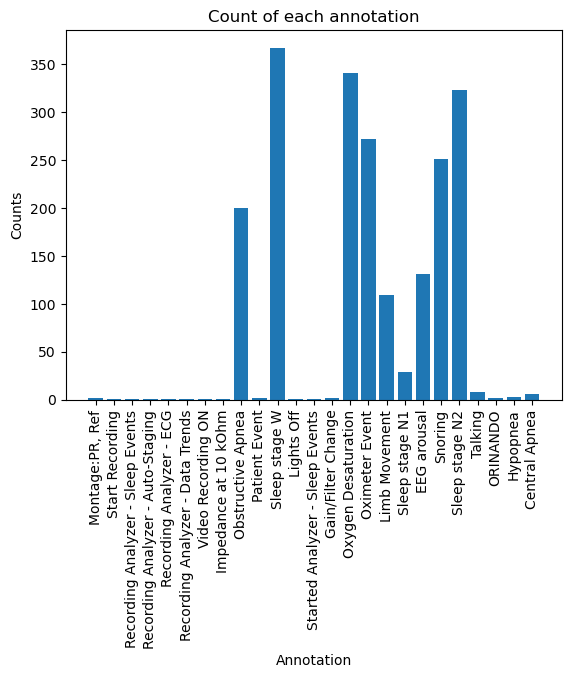

In [44]:
plt.figure()
plt.bar(cntr.keys(), cntr.values())
plt.xticks(rotation=90)
plt.xlabel("Annotation")
plt.ylabel("Counts")
plt.title("Count of each annotation")
plt.show()

As we can see, there are a lot of epochs marked with labels we don't care about. Later on we will see how we can filter the epochs to keep only the ones we care about.

## Extracting epochs from the full recordings

To be able to use the data, we need to extract 30s epochs from the full recordings. We can do that easily with the function `mne.make_fixed_length_epochs()`, but we can make use of the included annotations and use `mne.events_from_annotations()` and `mne.Epochs` to directly obtain the epochs paired with their associated label. 

> `mne.events_from_annotations()` allows us to filter by regexp, so we will be able to keep only the epochs corresponding to the labels we care about.

In [62]:
#| export
def get_epochs(data: mne.io.edf.edf.RawEDF, # Raw file loaded with `mne.io.read_raw_edf`.
               channels: List[str]=None, # List of channels to keep. If None all the channels are kept.
               ) -> Tuple[mne.epochs.Epochs, float]: # Epochs object and samplign rate of the signal.
    """Extracts labelled epochs from an already loaded raw edf file."""
    sampling_rate = data.info['sfreq']
    events, events_id = mne.events_from_annotations(data, regexp='Sleep stage [A-Z]\d*')

    tmax = 30. - 1. / sampling_rate  # tmax is included
    epochs = mne.Epochs(raw=data, 
                        events=events,
                        event_id=events_id,
                        tmin=0., 
                        tmax=tmax, 
                        baseline=None, 
                        event_repeated='merge',
                        picks=channels)

    epochs.drop_bad()
    return epochs, sampling_rate

In [48]:
epochs, sr = get_epochs(raw)

Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage W']
Not setting metadata
719 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 719 events and 3000 original time points ...
1 bad epochs dropped


When this objects are created without `preloading=True`, we need to use the method `.get_data()` to access the data. As this kind of data uses a lot of memmory, the data of each epoch only are loaded when this method is called.  We can check the shape of an epoch:

In [58]:
epochs[0].get_data().shape

Using data from preloaded Raw for 1 events and 3000 original time points ...


(1, 50, 3000)

The dimmensions of an epoch are: `(1, Number of channels, Data points per channel)`.

> Actually, the first dimmension corresponds to the number of epochs loaded, but we only loaded one epoch.

Lastly, this object stores two important atributes:

- `.events`: contains the parsed labels in the last dimension.
- `.event_id`: dictionary mapping the parsed labels to the original labels.

In [59]:
epochs.events

array([[ 228000,       0,       3],
       [ 231000,       0,       3],
       [ 234000,       0,       3],
       ...,
       [2373000,       0,       3],
       [2376000,       0,       3],
       [2379000,       0,       3]])

In [60]:
epochs.event_id

{'Sleep stage N1': 1, 'Sleep stage N2': 2, 'Sleep stage W': 3}

Comes to our attention that this patient has only been annotated with 3 out of 5 of the possible sleep stages. This might be important to look at to differentiate from full labeled patients and the rest.

## Inter-channel operations

Real practitioners don't actually use the data as we have imported it. They only utilize 9 channels, and perform reference operations between them. We can now reload the data using only this channels to save memory and perform the reference operations:

In [63]:
channels = ["C3", "C4", "A1", "A2", "O1", "O2", "LOC", "ROC", "LAT1", "LAT2", "ECGL", "ECGR", "CHIN1", "CHIN2"]

In [64]:
epochs, sr = get_epochs(raw, channels=channels)

Used Annotations descriptions: ['Sleep stage N1', 'Sleep stage N2', 'Sleep stage W']
Not setting metadata
719 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 719 events and 3000 original time points ...
1 bad epochs dropped


The reference operations they use are:

$$ C3 - \frac{A1+A2}{2} $$
$$ C4 - \frac{A1+A2}{2} $$
$$ 01 - \frac{A1+A2}{2} $$
$$ 02 - \frac{A1+A2}{2} $$
$$ LOC - A2 $$
$$ ROC - A1 $$
$$ LAT1 - LAT2 $$
$$ ECGL - ECGR $$
$$ CHIN1 - CHIN2 $$

In order to mantain the code clean, we can put our data into a dictionary and then perform the operations. But fist we will load all the data in memory:

In [65]:
X = epochs.get_data()
Y = epochs.events[:,-1]
X.shape, Y.shape

Using data from preloaded Raw for 718 events and 3000 original time points ...


((718, 14, 3000), (718,))

In [66]:
# We need to expand_dims to keep the channels dim
data = {ch:np.expand_dims(X[:,i,:],1) for i, ch in enumerate(channels)}

In [67]:
channel1 = data["C3"] - (data["A1"]+data["A2"])/2
channel2 = data["C4"] - (data["A1"]+data["A2"])/2
channel3 = data["O1"] - (data["A1"]+data["A2"])/2
channel4 = data["O2"] - (data["A1"]+data["A2"])/2
channel5 = data["LOC"] - data["A2"]
channel6 = data["ROC"] - data["A1"]
channel7 = data["LAT1"] - data["LAT2"]
channel8 = data["ECGL"] - data["ECGR"]
channel9 = data["CHIN1"] - data["CHIN2"]

Now we can concatenate the new channels into a new array:

In [68]:
X = np.concatenate([channel1, channel2, channel3, channel4, channel5, channel6, channel7, channel8, channel9],1)
X.shape

(718, 9, 3000)